In [1]:
# import commonly used libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from scipy.cluster.hierarchy import linkage, dendrogram
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
from data_processor import DataProcessor

# Initialize data processor
data_processor = DataProcessor("ancestry_unprocessed.csv", "ancestry_snps.csv")

# Run full pipeline
data_processor.load_data()
data_processor.remove_duplicates()
data_processor.define_snp_columns()
data_processor.standardize_genotypes()
data_processor.standardize_phenotype(trait_col='Population', new_col='Population_standardized')
data_processor.clean_columns()
data_processor.clean_rows()
data_processor.save_cleaned()

Sample size: 4221
Columns: ['ID-number', 'suppop', 'Subgroup', 'Population', 'rs10079352', 'rs10145636', 'rs10236187', 'rs10237550', 'rs1024522', 'rs1025542', 'rs1040045', 'rs10496971', 'rs10497191', 'rs10511828', 'rs10512572', 'rs10762771', 'rs10764919', 'rs1079597', 'rs10848243', 'rs10850061', 'rs11227699', 'rs1122927', 'rs11649804', 'rs1165196', 'rs11652805', 'rs11715610', 'rs1177298', 'rs11871320', 'rs1197062', 'rs12075', 'rs12203115', 'rs1229984', 'rs12476238', 'rs12498138', 'rs1250223', 'rs12629908', 'rs12657828', 'rs12913832', 'rs13070250', 'rs13266634', 'rs13280988', 'rs13400937', 'rs1407434', 'rs1426654', 'rs1431478', 'rs1470023', 'rs1471939', 'rs1513056', 'rs1513181', 'rs1541855', 'rs1557553', 'rs1569175', 'rs1572018', 'rs16891982', 'rs174570', 'rs17822931', 'rs1837606', 'rs1879488', 'rs192655', 'rs1942836', 'rs1950993', 'rs200354', 'rs2063164', 'rs2125345', 'rs2147896', 'rs2227203', 'rs2238151', 'rs2275075', 'rs2301723', 'rs2414167', 'rs2416791', 'rs2441727', 'rs2472304', 'r

In [3]:
# ====== Standardization and Grouping ====== #
# Import genotype processor
from genotype_processor import GenotypeProcessor

ancestry_cleaned = pd.read_csv('ancestry_cleaned.csv')
snp_cols = [col for col in ancestry_cleaned.columns if col.startswith('rs') or col.startswith('i')]

# Set up processor
genotype_processor = GenotypeProcessor(ancestry_cleaned,
                                       'Population_standardized',
                                       snp_cols=snp_cols)

# Print unique populations based on "Population" col.
genotype_processor.print_unique_traits('Population_standardized')

Unique Population_standardized: ['African ancestry in southwest us' 'African carribbeans in barbados'
 'Americans of african ancestry in sw usa'
 'C. african republic - biaka pygmy' 'D. r. of congo - mbuti pygmy'
 'Esan in nigera' 'Gambian in western divisons in the gambia'
 'Kenya - bantu' 'Luhya in webuye, kenya' 'Mende in sierra leone' 'Mkk'
 'Namibia - san' 'Nigeria - yoruba' 'Nigeria - yri hapmap'
 'Senegal - mandenka' 'South africa - bantu' 'Yoruba in ibadan, nigeria'
 'Puerto rican' 'Puerto ricans from puerto rico' 'Mexican ancestry'
 'Mexican ancestry from los angeles usa' 'Algeria (mzab) - mozabite' 'Chd'
 'China - dai' 'China - daur' 'China - han' 'China - hezhen'
 'China - lahu' 'China - miaozu' 'China - naxi' 'China - oroqen'
 'China - she' 'China - tu' 'China - tujia' 'China - uygur' 'China - xibo'
 'China - yizu' 'Chinese dai in xishuangbanna, china' 'Han chinese'
 'Japan - japanese' 'Japan - jpt hapmap' 'Japanese in tokyo, japan'
 'Korea - korean' 'Korean-2' 'She-1' 'She

In [4]:
# defines map for population standardization
pop_mapping = {
    # == Africa == #
    "African Ancestry": ['African Ancestry in Southwest US', 'Americans of African Ancestry in SW USA'],
    "African Caribbeans": ['African Caribbeans in Barbados', 'African Carribbeans in Barbados'],   
    "African Republic": ['C. African Republic - Biaka Pygmy'],
    "Algeria": ['Algeria (Mzab) - Mozabite'],
    "Congo": ['D. R. of Congo - Mbuti Pygmy', 'Congo - Mbuti'], 
    "Gambian": ['Gambian in Western Divisons in The Gambia'],
    "Nigeria": ['Esan in Nigeria', 'Nigeria - Yoruba', 'Nigeria - YRI HapMap', 'Yoruba in Ibadan, Nigeria',
                '03. Nigeria - Yoruba', 'Esan in Nigera'],
    "Kenya": ['Kenya - Bantu', 'Luhya in Webuye, Kenya', 'South Africa - Bantu', 'MKK'],
    "Namibia": ['Namibia - San'],
    "Senegal": ['Senegal - Mandenka'],
    "Sierra Leone": ['Mende in Sierra Leone'],
    # == South America == #
    "Colombian": ['Colombian', 'Colombians from Medellin, Colombia'], 
    "Mexican Ancestry": ['Mexican Ancestry', 'Mexican Ancestry from Los Angeles USA'], 
    "Peru": ['Peruvians from Lima, Peru (detected admixture)'],
    "Puerto Rican": ['Puerto Rican', 'Puerto Ricans from Puerto Rico'],
    # == Middle East == #
    "Druze": ['Israel (Carmel) - Druze'],
    "Palestinian": ['Israel (Central) - Palestinian', 'Israel(Central) - Palestinian'],
    "Bedouin": ['Israel (Negev) - Bedouin'],
    # == Asia == #
    "Bangladesh": ['Bengali from Bangladesh'],
    "Brunei": ['Brunei - Dusun'], 
    "Cambodia": ['Cambodia - Cambodian'],
    "CHD": ['CHD'],
    "China - Dai": ['China - Dai', 'Chinese Dai in Xishuangbanna, China'],
    "China - Daur": ['China - Daur'], 
    "China - Han": ['China - Han', 'Han Chinese',  'Southern Han Chinese'],
    "China - Hezhen": ['China - Hezhen'],
    "China - Lahu": ['China - Lahu'], 
    "China - Miaozu": ['China - Miaozu'],
    "China - Mongola": ['China - Mongola'],
    "China - Naxi": ['China - Naxi'], 
    "China - Oroqen": ['China - Oroqen'],
    "China - She": ['China - She', 'She-1', 'She-2'],
    "China - Tu": ['China - Tu', 'China - Tujia'],
    "China - Uygur": ['China - Uygur'], 
    "China - Xibo": ['China - Xibo'],
    "China - Yizu": ['China - Yizu'], 
    "India": ['Gujarati Indians in Houston, TX', 'Indian Telugu from the UK'],
    "Japan": ['Japan - Japanese', 'Japan - JPT HapMap', 'Japanese in Tokyo, Japan'],
    "Korea": ['Korea - Korean', 'Korean-2'],    
    "Kyrgyzstan": ['Kyrgyzstan - Kyrgyz', 'Kyrgyzystan - Kyrgyz'],
    "Melanesian": ['Bougainville - NAN Melanesian'], 
    "Pakistan": ['Pakistan - Balochi', 'Pakistan - Brahui', 'Pakistan - Burusho', 'Pakistan - Hazara',
                 'Pakistan - Kalash', 'Pakistan - Makrani', 'Pakistan - Pathan', 'Pakistan - Sindhi',
                 'Punjabi from Lahore, Pakistan'],
    "Sri Lanka": ['Sri Lankan Tamil from the UK'],
    "Thai": ['Thai-1', 'Thai-2'],
    "Vietnam": ['Kinh in Ho Chi Minh City, Vietnam'],
    # == Russia == #
    "Russia": ['Russia (Caucasus) - Adygei', 'Russia - Russian',
               'Russia - Tlingit', 'Russia - Aleut', 
               'Russia - Altaian', 'Russia - Chukchi', 'Russia - Itelman', 'Russia - Ulchi'],
    "Russia - Eskimo": ['Russia - Eskimo_Sireniki'],
    "Siberia - Yakut": ['Siberia - Yakut'],
    "Russia - Yakut": ['Russia - Yakut'],
    "Evens": ['Russia - Even'],
    # == Europe == #
    "British": ['British', 'British in England and Scotland'],
    "Finnish": ['Finnish in Finland'],
    "France": ['France - Basque', 'France - French'],
    "Iberian": ['Iberian population in Spain', 'Iberian populations in Spain'],
    "Icelandic": ['Icelandic-1', 'Icelandic-2'],
    "Italy": ['Italy - from Bergamo', 'Italy - Sardinian', 'Italy - Tuscan', 'Toscani in Italia', 'Toscani in Italy'],
    "Northern & Western European ancestry": ['Utah residents (CEPH) with Northern and Western European ancestry'],
    "Norwegian": ['Norwegian-1'],
    "Orcadian": ['Orkney Islands - Orcadian'],
    # == Native American == #
    "Native Americans": [
        'Argentina - Chane', 'Brazil - Karitiana', 'Brazil - Surui', 'Colombia - Piapoco',
        'Colombia - Piapoco and Curripaco', 'Mexico - Maya', 'Mexico - Mayan',
        'Mexico - Mixe', 'Mexico - Mixtec', 'Mexico - Pima', 'Mexico - Zapotec', 'Puerto Rican - Quechua'],
    # == Oceania == #
    "Papuan": ['New Guinea - Papuan', 'PapuaNewGuinea - Papuan'],
    "New Zealand": ['New Zealand - Maori'],
}

# Standardize population
ancestry_std = genotype_processor.standardize_traits(pop_mapping, 'Population', 'Population Standardized')
ancestry_std.to_csv('ancestry_standardized.csv', index=False)

genotype_processor.print_unique_traits('Population Standardized')

Unique Population Standardized: ['African Ancestry' 'African Caribbeans' 'African Republic' 'Congo'
 'Nigeria' 'Gambian' 'Kenya' 'Sierra Leone' 'Namibia' 'Senegal'
 'Puerto Rican' 'Mexican Ancestry' 'Algeria' 'CHD' 'China - Dai'
 'China - Daur' 'China - Han' 'China - Hezhen' 'China - Lahu'
 'China - Miaozu' 'China - Naxi' 'China - Oroqen' 'China - She'
 'China - Tu' 'China - Uygur' 'China - Xibo' 'China - Yizu' 'Japan'
 'Korea' 'Russia' 'British' 'Finnish' 'France' 'Iberian' 'Icelandic'
 'Italy' 'Norwegian' 'Orcadian' 'Northern & Western European ancestry'
 'Druze' 'Palestinian' 'Bedouin' 'Colombian' 'Native Americans'
 'China - Mongola' 'Russia - Eskimo' 'Evens' 'Russia - Yakut'
 'Siberia - Yakut' 'Melanesian' 'Papuan' 'New Zealand' 'Peru' 'Bangladesh'
 'India' 'Pakistan' 'Sri Lanka' 'Brunei' 'Cambodia' 'Vietnam' 'Thai'
 'Kyrgyzstan'],


In [5]:
# ===== Encode SNPs and plot PCA and MDS ===== #
# Load standardized data and SNP info
ancestry_standardized = pd.read_csv("ancestry_standardized.csv")
snp_info = pd.read_csv("ancestry_snps.csv").set_index('rsid')
snp_cols = [col for col in ancestry_standardized.columns if col.startswith('rs') or col.startswith('i')]

# Reset processor
genotype_processor = GenotypeProcessor(ancestry_standardized,
                                       'Population Standardized',
                                       snp_cols=snp_cols)

# Filter by minimum samples and impute missing genotypes
genotype_processor.filter_by_min_samples(6).impute_missing_genotypes('NN')

# Encode SNPs numerically
ancestry_encoded = genotype_processor.encode_snps(snp_info, effect_dosage=1, other_dosage=-1, missing_value=0)
ancestry_encoded.head(5)


--- Trait Counts (Bottom 10, After Filtering) ---
Population Standardized
China - Uygur      10
China - Mongola    10
China - Miaozu     10
China - Yizu       10
China - Daur        9
China - Xibo        9
China - Hezhen      9
China - Lahu        9
China - Naxi        9
China - Oroqen      9
Name: count, dtype: int64
-----------------------
Number of traits before filtering: 62
Number of traits after filtering:  51



,Population Standardized,rs10079352,rs10145636,rs10236187,rs10237550,rs1024522,rs1025542,rs1040045,rs10496971,rs10497191,...,rs853267,rs881728,rs917115,rs9291090,rs9319336,rs941984,rs946918,rs9911767,rs9919479,rs9934011
0,African Ancestry,0,2,0,-2,0,2,-2,-2,0,...,2,-2,0,-2,-2,2,-2,0,-2,0
1,African Ancestry,2,2,-2,2,-2,0,-2,-2,-2,...,2,-2,2,-2,0,0,0,-2,-2,-2
2,African Ancestry,2,0,0,2,0,2,-2,-2,-2,...,0,-2,2,-2,-2,2,-2,0,-2,-2
3,African Ancestry,2,2,0,2,-2,0,-2,-2,-2,...,2,-2,2,-2,-2,2,-2,-2,-2,0
4,African Ancestry,2,2,0,-2,-2,0,0,-2,0,...,0,-2,2,0,2,0,-2,-2,-2,0


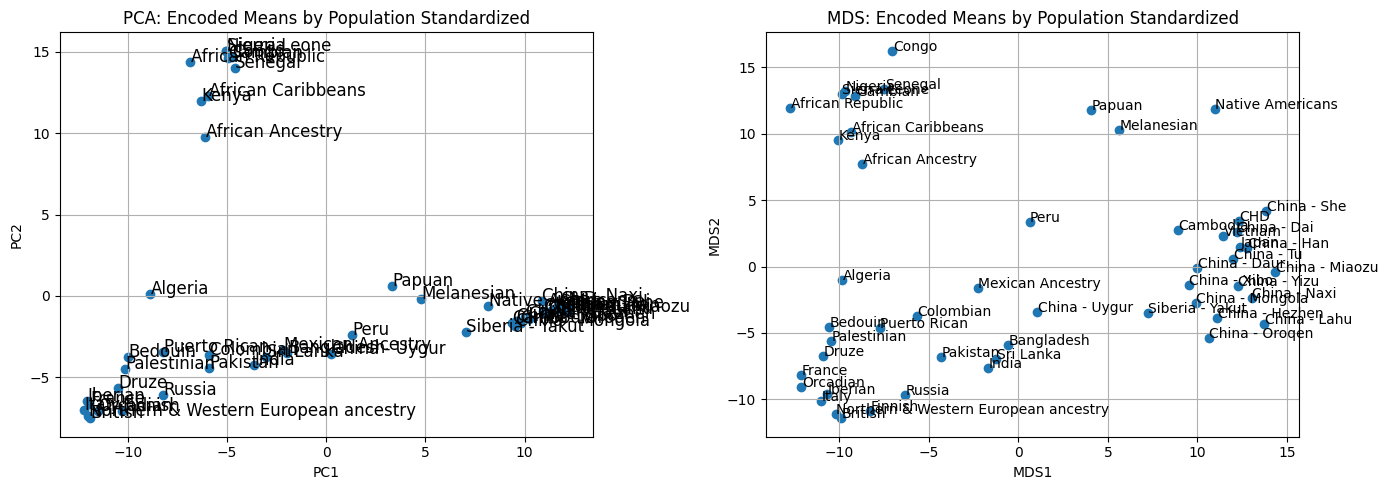

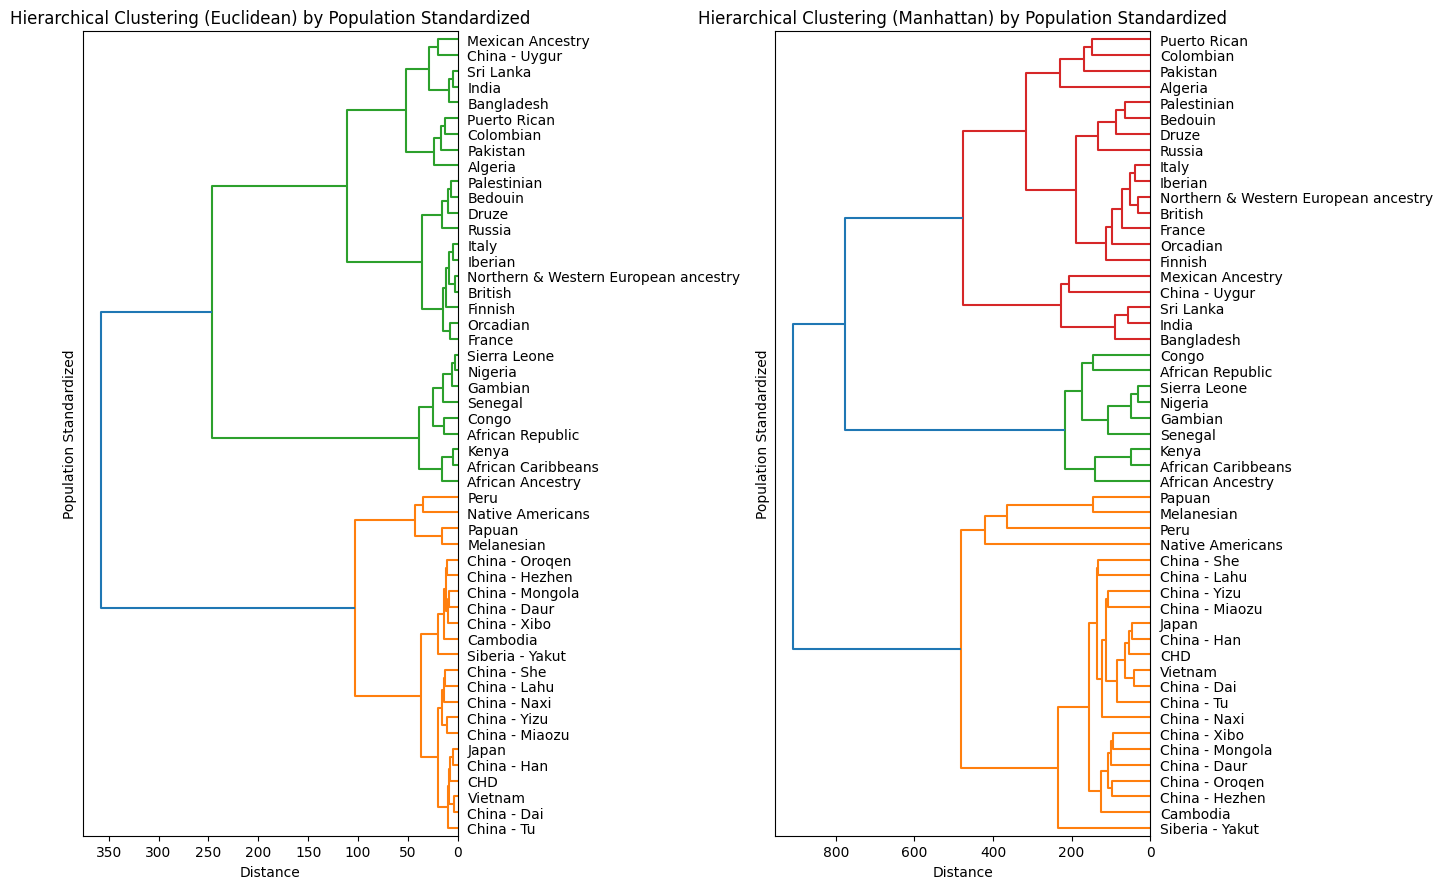

In [6]:
# Plot PCA and MDS
genotype_processor.plot_pca_mds(ancestry_encoded, 'Population Standardized')
# Plot dendrograms
genotype_processor.plot_dendrograms(ancestry_encoded, 'Population Standardized', figsize=(14, 9))

In [7]:
# Defines map for population grouping
group_mapping = {
  # == Africa == #
  "Africa": [
   'Namibia', 'African Republic', 'Sierra Leone', 'Senegal',
   'African Caribbeans', 'Kenya', 'African Ancestry', 'Congo',
   'Gambian', 'Nigeria', 'African (mixed)'],
  # == South America == #
    "Central and South America": [
     'Puerto Rican', 'Puerto Ricans from Puerto Rico',
     'Colombian', 'Colombians from Medellin, Colombia',
     'Mexican Ancestry', 'Mexican Ancestry from Los Angeles USA',
     'Peru'],
  # == Middle East == #
  "Middle East": [
   'Bedouin', 'Palestinian', 'Druze',
   'Middle Eastern (mixed)', 'Algeria'],
  # == Asia == #
  "East and Southeast Asia": [
   'China - Lahu', 'China - Naxi', 'China - Hezhen', 'China - Miaozu',
   'China - Xibo', 'China - Daur', 'China - She', 'China - Mongola',
   'China - Yizu', 'China - Oroqen', 'China - Tu',
   'CHD', 'China - Dai', 'China - Han', 'China - Uygur',
   'Japan', 'Korea', 'Cambodia', 'Thai', 'Brunei', 'Vietnam', 'Siberia - Yakut',
   'Evens', 'Kyrgyzstan'],
  # == South Asia == #    
  "South Asia": [
   'Bangladesh', 'Sri Lanka',
   'India', 'Pakistan',
   'South Asian'],
  # == Europe == #
  "Europe": [
   'British', 'Iberian', 'Northern & Western European ancestry',
   'Icelandic', 'Norwegian', 'Italy', 'France',
   'Finnish', 'Orcadian', 'Russia'],
  # == Native American == #
  "Native Americans": ['Native Americans'],
  # == Oceania == #
  "Oceania": ['New Zealand',
              'Melanesian',
              'Papuan'],
  # == Siberian ==
  "Siberian": [
   'Russia - Eskimo',
   'Russia - Yakut']
}

# Group populations based on ancestry_standardized
ancestry_grouped = genotype_processor.group_traits(group_mapping, 'Population Standardized', 
                                                   'Population Grouped')
ancestry_grouped.to_csv('ancestry_grouped.csv', index=False)

# Print unique population groups
genotype_processor.print_unique_traits('Population Grouped', ancestry_grouped)

Unique Population Grouped: ['Africa' 'Central and South America' 'Middle East'
 'East and Southeast Asia' 'Europe' 'Native Americans' 'Oceania'
 'South Asia'],


In [8]:
# Show all rows where 'Population Grouped' is nan
nan_rows = ancestry_grouped[ancestry_grouped['Population Grouped'].isna()]
nan_rows

,ID-number,suppop,Subgroup,Population,rs10079352,rs10145636,rs10236187,rs10237550,rs1024522,rs1025542,...,rs9291090,rs9319336,rs941984,rs946918,rs9911767,rs9919479,rs9934011,Population_standardized,Population Standardized,Population Grouped


In [9]:
# Load standardized data and SNP info
ancestry_grouped = pd.read_csv("ancestry_grouped.csv")
snp_cols = [col for col in ancestry_grouped.columns if col.startswith('rs') or col.startswith('i')]

# Reset processor
genotype_processor = GenotypeProcessor(ancestry_grouped,
                                       'Population Grouped',
                                       snp_cols=snp_cols)

# Filter by minimum samples and impute missing genotypes
genotype_processor.filter_by_min_samples(5).impute_missing_genotypes('NN')

# Encode SNPs numerically
ancestry_encoded = genotype_processor.encode_snps(snp_info)


--- Trait Counts (Bottom 10, After Filtering) ---
Population Grouped
Africa                       1025
East and Southeast Asia       939
Europe                        707
South Asia                    583
Central and South America     277
Middle East                   163
Native Americans               85
Oceania                        29
Name: count, dtype: int64
-----------------------
Number of traits before filtering: 8
Number of traits after filtering:  8



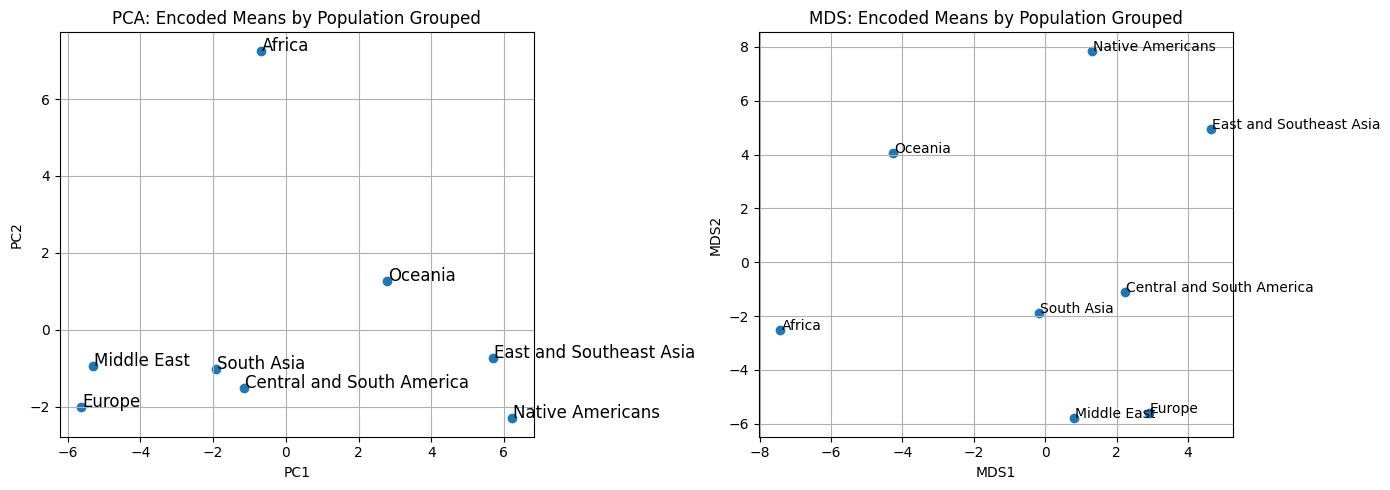

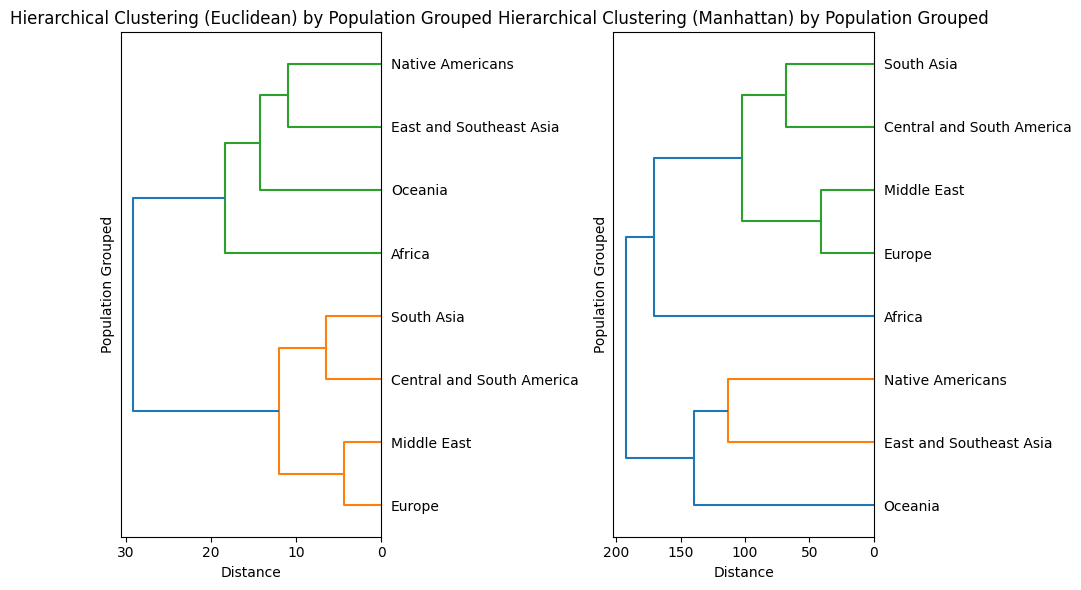

In [10]:
# Plot PCA and MDS
genotype_processor.plot_pca_mds(ancestry_encoded, 'Population Grouped')
# Plot dendrograms
genotype_processor.plot_dendrograms(ancestry_encoded, 'Population Grouped', figsize=(10, 6))


=== Class Distribution (Original) ===
Africa               Count: 1025   Frequency: 0.269
Central and South America Count:  277   Frequency: 0.073
East and Southeast Asia Count:  939   Frequency: 0.247
Europe               Count:  707   Frequency: 0.186
Middle East          Count:  163   Frequency: 0.043
Native Americans     Count:   85   Frequency: 0.022
Oceania              Count:   29   Frequency: 0.008
South Asia           Count:  583   Frequency: 0.153

=== Class Weights (Balanced) ===
Africa               Weight: 0.464
Central and South America Weight: 1.718
East and Southeast Asia Weight: 0.507
Europe               Weight: 0.673
Middle East          Weight: 2.920
Native Americans     Weight: 5.600
Oceania              Weight: 16.414
South Asia           Weight: 0.816

=== Evaluating Logistic Regression ===
                           precision    recall  f1-score   support

                   Africa       1.00      1.00      1.00      1025
Central and South America       0.90   

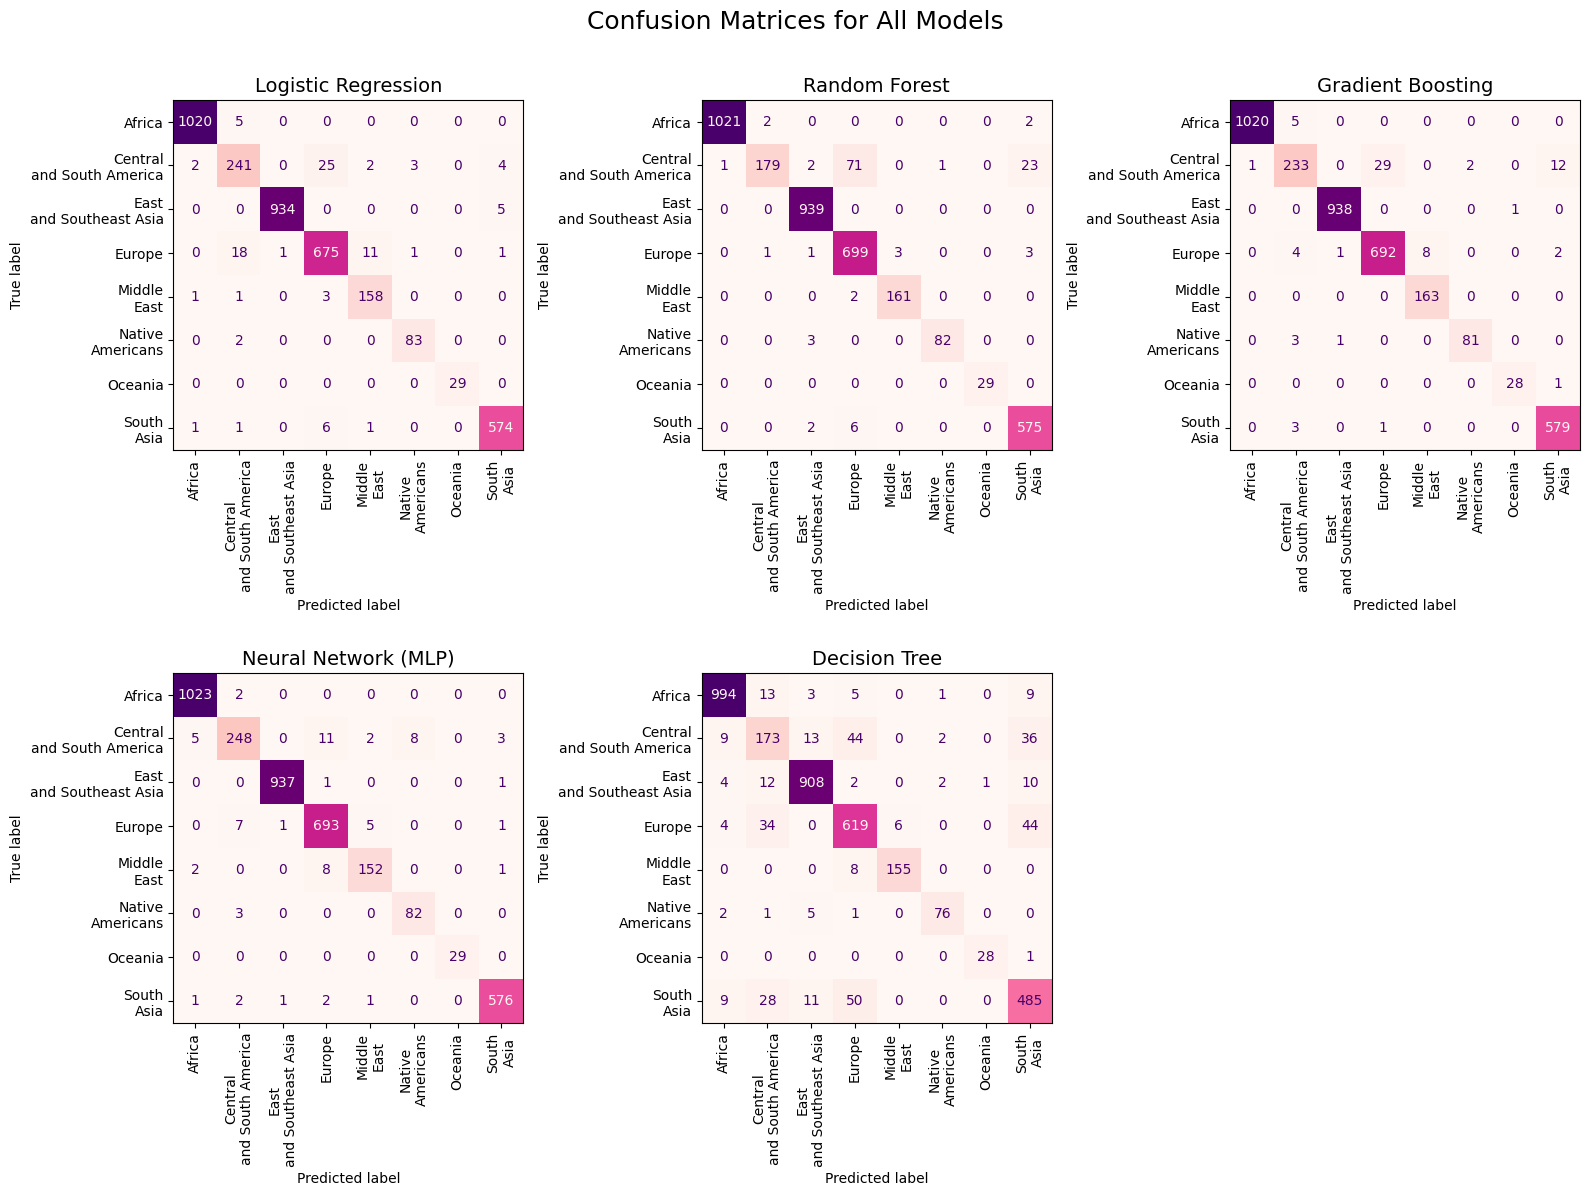


=== Model Comparison Summary ===
               Model  CV Accuracy  CV Weighted F1
 Logistic Regression         0.98            0.98
       Random Forest         0.97            0.97
   Gradient Boosting         0.98            0.98
Neural Network (MLP)         0.98            0.98
       Decision Tree         0.90            0.90
Model summary exported to: results\ancestry_model_comparison.csv
Classification reports exported to: results\ancestry_classification_reports.csv


In [11]:
from trait_classifier import TraitClassifier

# train models and evaluate
classifier = TraitClassifier(X=ancestry_encoded[snp_cols],
                             y=ancestry_encoded['Population Grouped'],
                             snp_cols=snp_cols,
                             label_name="Population Grouped",
                             out_prefix="ancestry")

classifier.evaluate()
classifier.export_results(prefix='ancestry')